# Setup

## [IMPORTANT] Please set the directory according to the path of your datasets!

In [ ]:
# TODO: You should set the following environment variable according to the path of your datasets
CSV_DIR = 'datasets/viewport'
SKETCH_DATASET_DIR = 'datasets/sketch'
DESIGN_DATASET_DIR = 'datasets/design'
ALL_RESULTS_DIR = 'experiment-results'

In [21]:
import logging
import json
import logging
import os

import pandas as pd
from utils.logger import setup_logger

logger: logging.Logger = logging.getLogger(__name__)

setup_logger(log_file_prefix="analysis_responsive")


CSV_WEIGHTAGES = {}

UNIQUE_VIEWPORTS = set()
for csv_file_name in ["desktop", "mobile", "tablet"]:
    csv_path = os.path.join(CSV_DIR, csv_file_name + ".csv")
    logger.info("Reading viewports from csv: %s", csv_path)
    df = pd.read_csv(csv_path)
    _weightage = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    CSV_WEIGHTAGES[csv_file_name] = {
        k: v for k, v in _weightage.items() if "x" in k}
    UNIQUE_VIEWPORTS.update(CSV_WEIGHTAGES[csv_file_name].keys())

2025-05-14 17:00:06,056 [INFO] logger.py:57: Logger is up.
2025-05-14 17:00:06,058 [WARNING] logger.py:59: Failed to reconfigure stdout encoding. Please check your console encoding.
2025-05-14 17:00:06,062 [INFO] 584079660.py:24: Reading viewports from csv: datasets/viewport\desktop.csv
2025-05-14 17:00:06,111 [INFO] 584079660.py:24: Reading viewports from csv: datasets/viewport\mobile.csv
2025-05-14 17:00:06,114 [INFO] 584079660.py:24: Reading viewports from csv: datasets/viewport\tablet.csv


# Data validation
If the JSON file is not matching with the requirements of the analysis, we will print out a warning here

In [22]:
ALL_RESULTS = set(["design", "design_only", "design_with_missing", "design_only_full","sketch", "sketch_with_missing", "sketch_only"])
for result_dir in os.listdir(ALL_RESULTS_DIR):
    cur_dir = os.path.join(ALL_RESULTS_DIR, result_dir)
    if not os.path.isdir(cur_dir):
        continue
    
    len_list = []
    json_files = os.listdir(cur_dir)
    for json_file in json_files:
        if not json_file.endswith(".json"):
            continue

        if not json_file.startswith("res_dict_eval__") or not json_file.endswith(".json"):
            continue
        
        csv_file_name = json_file.split('__')[1].split(".")[0]
        must_have_keys = set(CSV_WEIGHTAGES[csv_file_name].keys())
        with open(os.path.join(cur_dir, json_file), 'r') as f:
            viewport_dict_list: dict[list] = json.load(f)
            for key in must_have_keys:
                if key not in viewport_dict_list:
                    logger.warning("Key %s not found in %s from %s", key, json_file, cur_dir)
            
            # check if the len of list is the same across all keys
            len_list.extend([len(viewport_dict_list[key]) for key in must_have_keys])
            if len(set(len_list)) != 1:
                logger.warning("Length mismatch in %s from %s", json_file, cur_dir)
                print(set(len_list))
                continue

# Metrics calculation
This part is to be run after eval-responsive.py is run

In [23]:
import numpy as np
def get_score(json_dir: str, weightages: dict= CSV_WEIGHTAGES):
    json_files = os.listdir(json_dir)

    try_count_final = 0
    N = 0
    with open(os.path.join(json_dir, "res_dict.json"), 'r') as f:
        res_dict_list: list[dict] = json.load(f)
        for res_dict in res_dict_list:
            try_count_final += res_dict["try_count"]
        N = len(res_dict_list)
    try_count_final /= N
    
    logger.info("try_count_final: %f", try_count_final)
    logger.info("successful_attempts: %d", N)

    weighted_results_details: dict[str, dict[str, dict]] = {}
    weighted_results = {}

    visited_viewports = set()
    # {"id1": ["1920x1080": {"text_score": 0 ...}, "1366x768": {"text_score": 0, ...}] , "id2": ["1920x1080": {"text_score": 0 ...}, "1366x768": {"text_score": 0, ...}]  }
    pages_under_all_viewports_score_details: dict[str, list[dict[str, float]]] = {}
    # {"id1": {"text_score": 0, "text_score_std": 0, "text_score_max_diff": 0, "text_score_min_diff": 0}, "id2": {...} ...}
    pages_under_all_viewports_score: dict[str, dict[str, float]] = {}
    # collapse the above dict into one dict by aggregating the scores across all pages
    pages_under_all_viewports_score_into_one: dict[str, float] = {}

    viewports_results: dict[str, list[dict]] = {}
    for json_file in json_files:
        if not json_file.startswith("res_dict_eval__") or not json_file.endswith(".json"):
            continue

        csv_file_name = json_file.split('__')[1].split(".")[0]
        json_file_path = os.path.join(json_dir, json_file)

        json_data = {}

        with open(json_file_path, 'r') as f:
            json_data: dict[str, list[dict]] = json.load(f)

        weighted_scores = {
            "text_score": 0,
            "text_score_std": 0,
            "size_score": 0,
            "size_score_std": 0,
            "position_score": 0,
            "position_score_std": 0,
            "color_score": 0,
            "color_score_std": 0,
            "clip_score": 0,
            "clip_score_std": 0,
            "final_score": 0,
            "final_score_std": 0,
        }
        weighted_total = 0
        weighted_results_details[csv_file_name] = {}

        for viewport, weight in weightages[csv_file_name].items():
            if viewport not in json_data:
                logger.warning("Key %s not found in %s from %s", viewport, json_file, json_dir)
                continue
            
            # get average of the scores
            text_score = np.mean([res["text_score"] for res in json_data[viewport]])
            size_score = np.mean([res["size_score"] for res in json_data[viewport]])
            position_score = np.mean([res["position_score"] for res in json_data[viewport]])
            color_score = np.mean([res["color_score"] for res in json_data[viewport]])
            clip_score = np.mean([res["clip_score"] for res in json_data[viewport]])
            final_score = np.mean([res["final_score"] for res in json_data[viewport]])

            # get the std of the scores 
            text_score_std = np.std([res["text_score"] for res in json_data[viewport]])
            size_score_std = np.std([res["size_score"] for res in json_data[viewport]])
            position_score_std = np.std([res["position_score"] for res in json_data[viewport]])
            color_score_std = np.std([res["color_score"] for res in json_data[viewport]])
            clip_score_std = np.std([res["clip_score"] for res in json_data[viewport]])
            final_score_std = np.std([res["final_score"] for res in json_data[viewport]])

            # save up the sum of scores in a dict
            weighted_results_details[csv_file_name][viewport] = {
                "text_score": text_score,
                "text_score_std": text_score_std,
                "size_score": size_score,
                "size_score_std": size_score_std,
                "position_score": position_score,
                "position_score_std": position_score_std,
                "color_score": color_score,
                "color_score_std": color_score_std,
                "clip_score": clip_score,
                "clip_score_std": clip_score_std,
                "final_score": final_score,
                "final_score_std": final_score_std,
            }
            
            # save up the results, weighted by the weightage
            weighted_scores["text_score"] += text_score * weight
            weighted_scores["text_score_std"] += text_score_std * weight
            weighted_scores["size_score"] += size_score * weight
            weighted_scores["size_score_std"] += size_score_std * weight
            weighted_scores["position_score"] += position_score * weight
            weighted_scores["position_score_std"] += position_score_std * weight
            weighted_scores["color_score"] += color_score * weight
            weighted_scores["color_score_std"] += color_score_std * weight
            weighted_scores["clip_score"] += clip_score * weight
            weighted_scores["clip_score_std"] += clip_score_std * weight
            weighted_scores["final_score"] += final_score * weight
            weighted_scores["final_score_std"] += final_score_std * weight

            weighted_total += weight
        
        # normalize the weighted scores
        weighted_scores["text_score"] /= weighted_total
        weighted_scores["text_score_std"] /= weighted_total
        weighted_scores["size_score"] /= weighted_total
        weighted_scores["size_score_std"] /= weighted_total
        weighted_scores["position_score"] /= weighted_total
        weighted_scores["position_score_std"] /= weighted_total
        weighted_scores["color_score"] /= weighted_total
        weighted_scores["color_score_std"] /= weighted_total
        weighted_scores["clip_score"] /= weighted_total
        weighted_scores["clip_score_std"] /= weighted_total
        weighted_scores["final_score"] /= weighted_total
        weighted_scores["final_score_std"] /= weighted_total

        weighted_results[csv_file_name] = weighted_scores

        # Gain insights on the standard deviations across viewports
        # Gain insights on how viewports may affect the scores, assuming they have the same weightage
        # collect the results for each viewport

        for viewport, weight in weightages[csv_file_name].items():
            if viewport in visited_viewports:
                continue
            visited_viewports.add(viewport)
            if viewport not in json_data:
                logger.warning("Key %s not found in %s from %s",
                               viewport, json_file, json_dir)
                continue
            
            # get the scores for each id under all viewports
            for res in json_data[viewport]:
                if "id" not in res:
                    logger.warning("Key %s not found in %s from %s",
                                   "id", json_file, json_dir)
                    continue
                
                res["viewport"] = viewport
                if res["id"] not in pages_under_all_viewports_score_details:
                    pages_under_all_viewports_score_details[res["id"]] = [res]
                else:
                    pages_under_all_viewports_score_details[res["id"]].append(
                        res)

            viewports_results[viewport] = json_data[viewport] 

        # get the average and std of the scores for each id under all viewports
        for page_id, page_details in pages_under_all_viewports_score_details.items():
            pages_under_all_viewports_score[page_id] = {
                "text_score": np.mean([res["text_score"] for res in page_details]),
                "text_score_std": np.std([res["text_score"] for res in page_details]),
                "text_score_max_diff": np.max([res["text_score"] for res in page_details]) - np.min([res["text_score"] for res in page_details]),
                # find the res that has the max text_score, and what is the viewport of that res
                "text_score_max_diff_viewports_max": [res['viewport'] for res in page_details if res['text_score'] == np.max([res['text_score'] for res in page_details])],
                "text_score_max_diff_viewports_min": [res['viewport'] for res in page_details if res['text_score'] == np.min([res['text_score'] for res in page_details])],
                # minimum differences between any two scores
                "text_score_min_diff": np.min([abs(page_details[i]["text_score"] - page_details[j]["text_score"]) for i in range(len(page_details)) for j in range(len(page_details)) if i != j]),
                "size_score": np.mean([res["size_score"] for res in page_details]),
                "size_score_std": np.std([res["size_score"] for res in page_details]),
                "size_score_max_diff": np.max([res["size_score"] for res in page_details]) - np.min([res["size_score"] for res in page_details]),
                "size_score_max_diff_viewports_max": [res['viewport'] for res in page_details if res['size_score'] == np.max([res['size_score'] for res in page_details])],
                "size_score_max_diff_viewports_min": [res['viewport'] for res in page_details if res['size_score'] == np.min([res['size_score'] for res in page_details])],
                "size_score_min_diff": np.min([abs(page_details[i]["size_score"] - page_details[j]["size_score"]) for i in range(len(page_details)) for j in range(len(page_details)) if i != j]),
                "position_score": np.mean([res["position_score"] for res in page_details]),
                "position_score_std": np.std([res["position_score"] for res in page_details]),
                "position_score_max_diff": np.max([res["position_score"] for res in page_details]) - np.min([res["position_score"] for res in page_details]),
                "position_score_max_diff_viewports_max": [res['viewport'] for res in page_details if res['position_score'] == np.max([res['position_score'] for res in page_details])],
                "position_score_max_diff_viewports_min": [res['viewport'] for res in page_details if res['position_score'] == np.min([res['position_score'] for res in page_details])],
                "position_score_min_diff": np.min([abs(page_details[i]["position_score"] - page_details[j]["position_score"]) for i in range(len(page_details)) for j in range(len(page_details)) if i != j]),
                "color_score": np.mean([res["color_score"] for res in page_details]),
                "color_score_std": np.std([res["color_score"] for res in page_details]),
                "color_score_max_diff": np.max([res["color_score"] for res in page_details]) - np.min([res["color_score"] for res in page_details]),
                "color_score_max_diff_viewports_max": [res['viewport'] for res in page_details if res['color_score'] == np.max([res['color_score'] for res in page_details])],
                "color_score_max_diff_viewports_min": [res['viewport'] for res in page_details if res['color_score'] == np.min([res['color_score'] for res in page_details])],
                "color_score_min_diff": np.min([abs(page_details[i]["color_score"] - page_details[j]["color_score"]) for i in range(len(page_details)) for j in range(len(page_details)) if i != j]),
                "clip_score": np.mean([res["clip_score"] for res in page_details]),
                "clip_score_std": np.std([res["clip_score"] for res in page_details]),
                "clip_score_max_diff": np.max([res["clip_score"] for res in page_details]) - np.min([res["clip_score"] for res in page_details]),
                "clip_score_max_diff_viewports_max": [res['viewport'] for res in page_details if res['clip_score'] == np.max([res['clip_score'] for res in page_details])],
                "clip_score_max_diff_viewports_min": [res['viewport'] for res in page_details if res['clip_score'] == np.min([res['clip_score'] for res in page_details])],
                "clip_score_min_diff": np.min([abs(page_details[i]["clip_score"] - page_details[j]["clip_score"]) for i in range(len(page_details)) for j in range(len(page_details)) if i != j]),
                "final_score": np.mean([res["final_score"] for res in page_details]),
                "final_score_std": np.std([res["final_score"] for res in page_details]),
                "final_score_max_diff": np.max([res["final_score"] for res in page_details]) - np.min([res["final_score"] for res in page_details]),
                "final_score_max_diff_viewports_max": [res['viewport'] for res in page_details if res['final_score'] == np.max([res['final_score'] for res in page_details])],
                "final_score_max_diff_viewports_min": [res['viewport'] for res in page_details if res['final_score'] == np.min([res['final_score'] for res in page_details])],
                "final_score_min_diff": np.min([abs(page_details[i]["final_score"] - page_details[j]["final_score"]) for i in range(len(page_details)) for j in range(len(page_details)) if i != j]),
            }

        pages_under_all_viewports_score_into_one = {
            "size_score": np.mean([res["size_score"] for res in pages_under_all_viewports_score.values()]),
            "size_score_std_across_pages": np.std([res["size_score"] for res in pages_under_all_viewports_score.values()]),
            "size_score_max_diff": np.max([res["size_score_max_diff"] for res in pages_under_all_viewports_score.values()]),
            "size_score_min_diff": np.min([res["size_score_min_diff"] for res in pages_under_all_viewports_score.values()]),
            "text_score": np.mean([res["text_score"] for res in pages_under_all_viewports_score.values()]),
            "text_score_std_across_pages": np.std([res["text_score"] for res in pages_under_all_viewports_score.values()]),
            "text_score_max_diff": np.max([res["text_score_max_diff"] for res in pages_under_all_viewports_score.values()]),
            "text_score_min_diff": np.min([res["text_score_min_diff"] for res in pages_under_all_viewports_score.values()]),
            
            "position_score": np.mean([res["position_score"] for res in pages_under_all_viewports_score.values()]),
            "position_score_std_across_pages": np.std([res["position_score"] for res in pages_under_all_viewports_score.values()]),
            "position_score_max_diff": np.max([res["position_score_max_diff"] for res in pages_under_all_viewports_score.values()]),
            "position_score_min_diff": np.min([res["position_score_min_diff"] for res in pages_under_all_viewports_score.values()]),
            "color_score": np.mean([res["color_score"] for res in pages_under_all_viewports_score.values()]),
            "color_score_std_across_pages": np.std([res["color_score"] for res in pages_under_all_viewports_score.values()]),
            "color_score_max_diff": np.max([res["color_score_max_diff"] for res in pages_under_all_viewports_score.values()]),
            "color_score_min_diff": np.min([res["color_score_min_diff"] for res in pages_under_all_viewports_score.values()]),
            "clip_score": np.mean([res["clip_score"] for res in pages_under_all_viewports_score.values()]),
            "clip_score_std_across_pages": np.std([res["clip_score"] for res in pages_under_all_viewports_score.values()]),
            "clip_score_max_diff": np.max([res["clip_score_max_diff"] for res in pages_under_all_viewports_score.values()]),
            "clip_score_min_diff": np.min([res["clip_score_min_diff"] for res in pages_under_all_viewports_score.values()]),
            "final_score": np.mean([res["final_score"] for res in pages_under_all_viewports_score.values()]),
            "final_score_std_across_pages": np.std([res["final_score"] for res in pages_under_all_viewports_score.values()]),
            "final_score_max_diff": np.max([res["final_score_max_diff"] for res in pages_under_all_viewports_score.values()]),
            "final_score_min_diff": np.min([res["final_score_min_diff"] for res in pages_under_all_viewports_score.values()]),
        }
    
    viewport_results_dict_details: dict[str, dict[str, float]] = {}
    for viewport, results in viewports_results.items():
        viewport_results_dict = {
            "text_score": np.mean([res["text_score"] for res in results]),
            "size_score": np.mean([res["size_score"] for res in results]),
            "position_score": np.mean([res["position_score"] for res in results]),
            "color_score": np.mean([res["color_score"] for res in results]),
            "clip_score": np.mean([res["clip_score"] for res in results]),
            "final_score": np.mean([res["final_score"] for res in results]),
        }
        viewport_results_dict_details[viewport] = viewport_results_dict
    
    viewport_results_std = {
        "size_score_std": np.std([res["size_score"] for res in viewport_results_dict_details.values()]),
        "text_score_std": np.std([res["text_score"] for res in viewport_results_dict_details.values()]),
        "position_score_std": np.std([res["position_score"] for res in viewport_results_dict_details.values()]),
        "color_score_std": np.std([res["color_score"] for res in viewport_results_dict_details.values()]),
        "clip_score_std": np.std([res["clip_score"] for res in viewport_results_dict_details.values()]),
        "final_score_std": np.std([res["final_score"] for res in viewport_results_dict_details.values()]),
    }
    
    # save all results to a json file
    success_count_and_try_count_path = os.path.join(json_dir, "success_count_and_try_count.json")
    with open(success_count_and_try_count_path, 'w') as f:
        json.dump({"successful_attempts": N, "try_count_final": try_count_final}, f, indent=4)
    weighted_results_details_path = os.path.join(json_dir, "weighted_results_details.json")
    with open(weighted_results_details_path, 'w') as f:
        json.dump(weighted_results_details, f, indent=4)
    weighted_result_json_path = os.path.join(json_dir, "weighted_results.json")
    with open(weighted_result_json_path, 'w') as f:
        json.dump(weighted_results, f, indent=4)
    pages_under_all_viewports_score_details_path = os.path.join(
        json_dir, "pages_under_all_viewports_score_details.json")
    with open(pages_under_all_viewports_score_details_path, 'w') as f:
        json.dump(pages_under_all_viewports_score_details, f, indent=4)
    pages_under_all_viewports_score_path = os.path.join(
        json_dir, "pages_under_all_viewports_score.json")
    with open(pages_under_all_viewports_score_path, 'w') as f:
        json.dump(pages_under_all_viewports_score, f, indent=4)
    pages_under_all_viewports_score_into_one_path = os.path.join(
        json_dir, "pages_under_all_viewports_score_into_one.json")
    with open(pages_under_all_viewports_score_into_one_path, 'w') as f:
        json.dump(pages_under_all_viewports_score_into_one, f, indent=4)
    logger.info("Results saved to %s", json_dir)
    with open(os.path.join(json_dir, "viewport_results_details.json"), 'w') as f:
        json.dump(viewport_results_dict_details, f, indent=4)
    with open(os.path.join(json_dir, "viewport_results_std.json"), 'w') as f:
        json.dump(viewport_results_std, f, indent=4)


    return {"successful_attempts": N, "try_count_final": try_count_final}, weighted_results_details, weighted_results, pages_under_all_viewports_score_details, pages_under_all_viewports_score, pages_under_all_viewports_score_into_one, viewport_results_dict_details, viewport_results_std

Run the following code to get the standard deviation of the scores output as a CSV file

This CSV file will have the standard deviation of all models using that prompting technique that you choose below

In [24]:
chosen = "sketch"  # prompting technique that we chose to generate the CSV file for

In [35]:
ALL_RESULTS = set(["design", "design_only", "design_with_missing",
                  "design_only_full", "sketch", "sketch_with_missing", "sketch_only"])
import pandas as pd
if "design" in chosen and "design" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"design"}

if "sketch" in chosen and "sketch" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"sketch"}

if "design_only" in chosen and "design_only" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"design_only"}

if "sketch_only" in chosen and "sketch_only" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"sketch_only"}

final_csv = []
for result_dir in os.listdir(ALL_RESULTS_DIR):
    cur_dir = os.path.join(ALL_RESULTS_DIR, result_dir)
    if not os.path.isdir(cur_dir):
        continue

    # exclude the directory if the directory name contains some elements in ALL_RESULTS, other than the chosen one
    if any(x in result_dir for x in ALL_RESULTS - {chosen}):
        continue

    if chosen not in result_dir:
        continue

    success_rate, weight_details, weight, score_details, score, score_into_one, _, std = get_score(
        cur_dir)
    logger.info("Results for %s: %s", result_dir, std)
    std["result_dir"] = result_dir
    # save the results to a csv file
    # wrap in list to make a single-row DataFrame
    df = pd.DataFrame([std])
    final_csv.append(df)

results_path = "temp-results-std.csv"
if os.path.exists(results_path):
    os.remove(results_path)

# Define the desired model order using substrings
model_order = [
    "gemma2", "gemma3", "llama3.2-vision", "llama3.2-vision_90b",
    "gpt-4o", "gemini-2.0-flash", "grok-2-vision"
]

# Helper to assign sort key based on substring match


def extract_model_order_index(result_dir):
    for idx, tag in enumerate(model_order):
        if "llama3.2-vision" in result_dir and "llama3.2-vision_90b" in result_dir:
            return 3
        if tag in result_dir:
            return idx
    return len(model_order)  # Put anything unmatched at the end


# Apply sort key and sort
final_df = pd.concat(final_csv, axis=0, ignore_index=True)
final_df["sort_order"] = final_df["result_dir"].apply(
    extract_model_order_index)
final_df = final_df.sort_values("sort_order").drop(columns=["sort_order"])

# Step 1: Move result_dir to first column
cols = final_df.columns.tolist()
cols.remove("result_dir")
final_df = final_df[["result_dir"] + cols]

# Step 2: Keep only columns that are the value or std (not max/min diff)
# Retain only columns that end with nothing (value columns) or end with "_std_across_pages"
keep_columns = ["result_dir"] + [
    col for col in final_df.columns
    if col.endswith("_std_across_pages") or (
        not col.endswith("_max_diff") and
        not col.endswith("_min_diff") and
        not col.endswith("_std_across_pages") and  # already included above
        "_diff" not in col  # catch anything else
    )
]

final_df = final_df[keep_columns]
final_df.to_csv(results_path, index=False)
logger.info("CSV save to %s", results_path)

2025-05-14 17:05:25,230 [INFO] 11678604.py:14: try_count_final: 1.000000
2025-05-14 17:05:25,231 [INFO] 11678604.py:15: successful_attempts: 15
2025-05-14 17:05:25,462 [INFO] 11678604.py:270: Results saved to experiment-results\azure_sketch.py_gpt-4o_20250514-150000
2025-05-14 17:05:25,466 [INFO] 1239128810.py:31: Results for azure_sketch.py_gpt-4o_20250514-150000: {'size_score_std': np.float64(0.0015083479321717015), 'text_score_std': np.float64(0.00028136769036773453), 'position_score_std': np.float64(0.011971670360615598), 'color_score_std': np.float64(0.0008540123100113679), 'clip_score_std': np.float64(0.0064976935117055), 'final_score_std': np.float64(0.0020358906683689173)}
2025-05-14 17:05:25,478 [INFO] 1239128810.py:85: CSV save to temp-results-std.csv


Run the following code to get the score output as a CSV file 

This CSV file will have the scores of all models using that prompting technique that you choose below

In [26]:
chosen = "sketch" # prompting technique that we chose to generate the CSV file for

In [34]:
import pandas as pd
ALL_RESULTS = set(["design", "design_only", "design_with_missing",
                  "design_only_full", "sketch", "sketch_with_missing", "sketch_only"])

if "design" in chosen and "design" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"design"}
        
if "sketch" in chosen and "sketch" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"sketch"}
        
if "design_only" in chosen and "design_only" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"design_only"}

if "sketch_only" in chosen and "sketch_only" != chosen:
    ALL_RESULTS = ALL_RESULTS - {"sketch_only"}

final_csv = []   
for result_dir in os.listdir(ALL_RESULTS_DIR):
    cur_dir = os.path.join(ALL_RESULTS_DIR, result_dir)
    if not os.path.isdir(cur_dir):
        continue
    
    # exclude the directory if the directory name contains some elements in ALL_RESULTS, other than the chosen one
    if any(x in result_dir for x in ALL_RESULTS - {chosen}):
        continue
    
    if chosen not in result_dir:
        continue

    success_rate, weight_details, weight, score_details, score, score_into_one, _, _ = get_score(cur_dir)
    logger.info("Results for %s: %s", result_dir, score_into_one)
    score_into_one["result_dir"] = result_dir  
    # save the results to a csv file
    # wrap in list to make a single-row DataFrame
    df = pd.DataFrame([score_into_one])
    final_csv.append(df)

results_path = "temp-results.csv"
if os.path.exists(results_path):
    os.remove(results_path)

# Define the desired model order using substrings
model_order = [
    "gemma2", "gemma3", "llama3.2-vision", "llama3.2-vision_90b",
    "gpt-4o", "gemini-2.0-flash", "grok-2-vision"
]

# Helper to assign sort key based on substring match


def extract_model_order_index(result_dir):
    for idx, tag in enumerate(model_order):
        if "llama3.2-vision" in result_dir and "llama3.2-vision_90b" in result_dir:
            return 3
        if tag in result_dir:
            return idx
    return len(model_order)  # Put anything unmatched at the end


# Apply sort key and sort
final_df = pd.concat(final_csv, axis=0, ignore_index=True)
final_df["sort_order"] = final_df["result_dir"].apply(
    extract_model_order_index)
final_df = final_df.sort_values("sort_order").drop(columns=["sort_order"])

# Step 1: Move result_dir to first column
cols = final_df.columns.tolist()
cols.remove("result_dir")
final_df = final_df[["result_dir"] + cols]

# Step 2: Keep only columns that are the value or std (not max/min diff)
# Retain only columns that end with nothing (value columns) or end with "_std_across_pages"
keep_columns = ["result_dir"] + [
    col for col in final_df.columns
    if col.endswith("_std_across_pages") or (
        not col.endswith("_max_diff") and
        not col.endswith("_min_diff") and
        not col.endswith("_std_across_pages") and  # already included above
        "_diff" not in col  # catch anything else
    )
]

final_df = final_df[keep_columns]
final_df.to_csv(results_path, index=False)
logger.info("CSV save to %s", results_path)

2025-05-14 17:05:05,698 [INFO] 11678604.py:14: try_count_final: 1.000000
2025-05-14 17:05:05,699 [INFO] 11678604.py:15: successful_attempts: 15
2025-05-14 17:05:05,906 [INFO] 11678604.py:270: Results saved to experiment-results\azure_sketch.py_gpt-4o_20250514-150000
2025-05-14 17:05:05,909 [INFO] 2028305383.py:31: Results for azure_sketch.py_gpt-4o_20250514-150000: {'size_score': np.float64(0.8998171342053366), 'size_score_std_across_pages': np.float64(0.2284529755147425), 'size_score_max_diff': np.float64(0.12925373107891236), 'size_score_min_diff': np.float64(0.0), 'text_score': np.float64(0.9693702925084562), 'text_score_std_across_pages': np.float64(0.02211859382695798), 'text_score_max_diff': np.float64(0.008953065083961764), 'text_score_min_diff': np.float64(0.0), 'position_score': np.float64(0.904851046064632), 'position_score_std_across_pages': np.float64(0.07688782971838892), 'position_score_max_diff': np.float64(0.2768073981762128), 'position_score_min_diff': np.float64(0.0),

# Individual query

You can use the code below to compare between the generated website and the expected design. You can choose the viewports as well.

In [ ]:
# Input your query here
chosen_dir = "azure_sketch.py_gpt-4o_20250514-150000"
original_design_dir = SKETCH_DATASET_DIR
uid_queries = [
    "7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4"]
viewport_queries = ["375x667", "1920x1080"]

2025-05-14 17:02:13,309 [INFO] 448609275.py:55: Results: [{'id': '7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4', 'filename': '7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4_merge-sketch_out.html', 'sum_sum_areas': 0.2922354117035955, 'final_score': 0.9765685652100731, 'size_score': 0.9538817735351454, 'text_score': 0.9822052718340907, 'position_score': 0.9975616042881985, 'color_score': 0.9708275630048693, 'clip_score': 0.9783666133880615, 'try_count': 1, 'viewport': '1920x1080'}, {'id': '7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4', 'filename': '7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4_merge-sketch_out.html', 'sum_sum_areas': 0.8995934774106961, 'final_score': 0.9742854631652904, 'size_score': 0.9454869688557171, 'text_score': 0.9822052718340907, 'position_score': 0.9921180295382381, 'color_score': 0.9708275630048693, 'clip_score': 0.9807894825935364, 'try_count': 1, 'viewport': '375x667'}]
2025-05-14 1

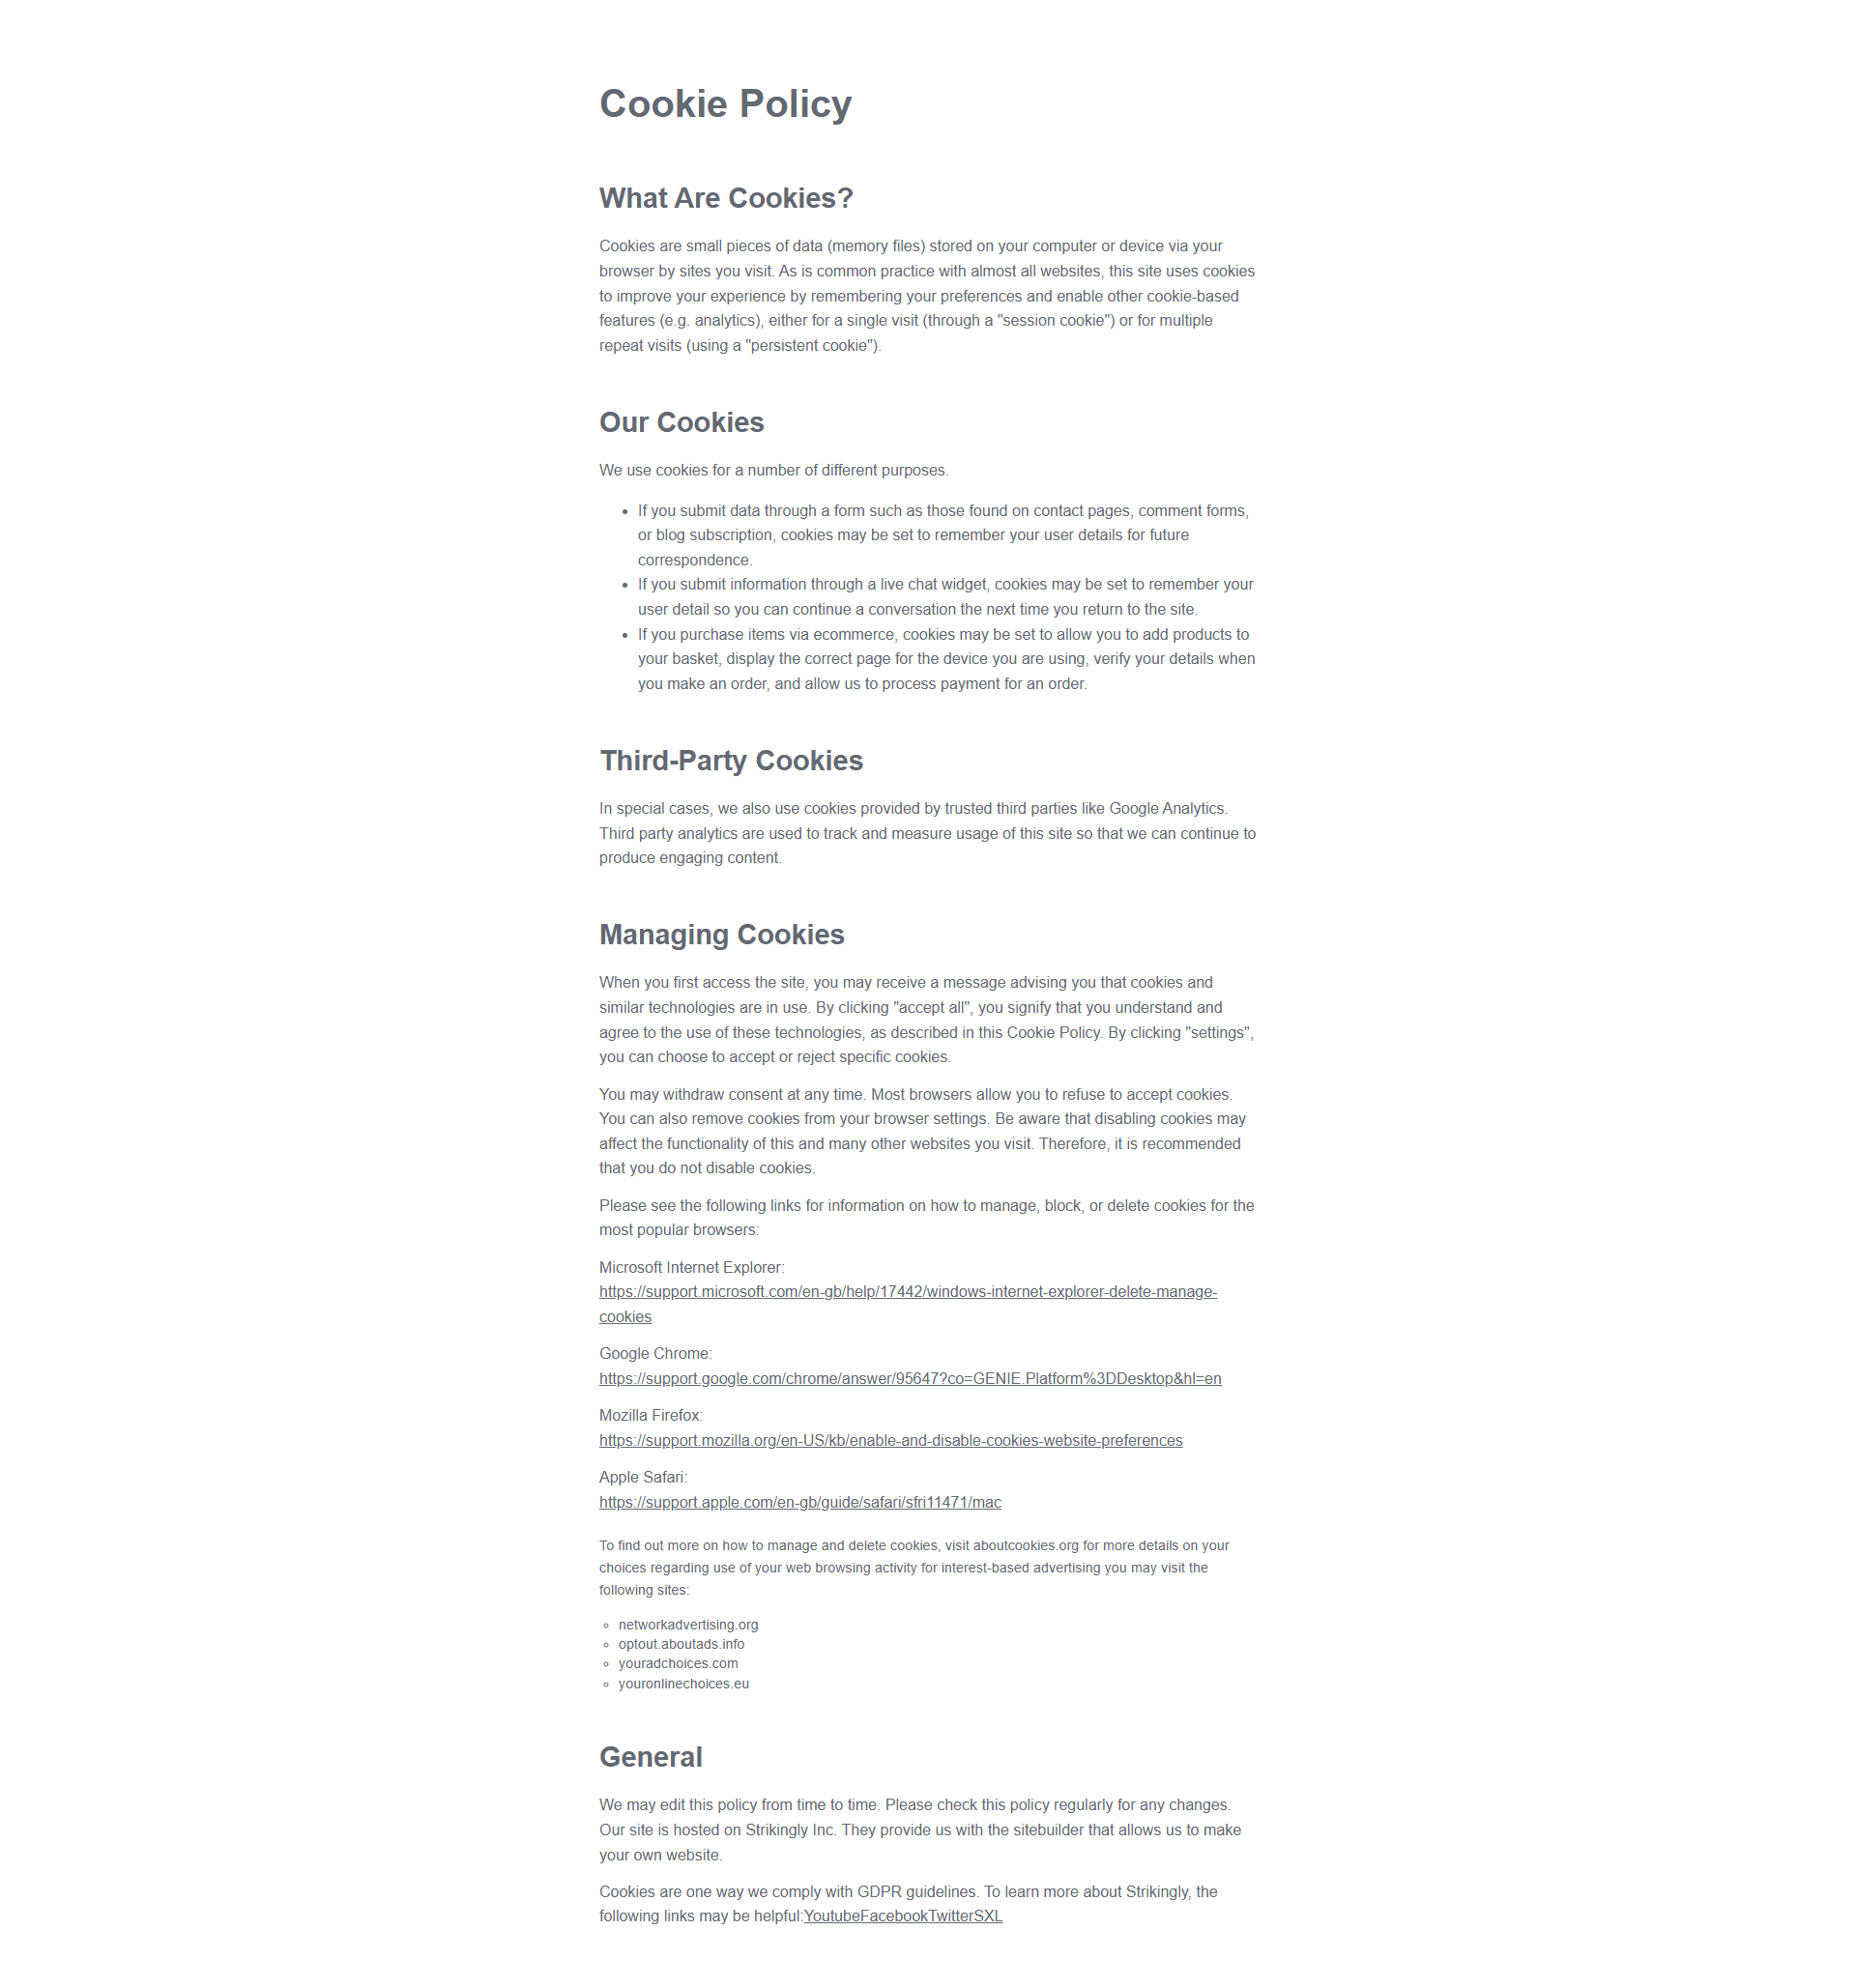

2025-05-14 17:02:18,115 [INFO] 448609275.py:82: Original html path: datasets/sketch\7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4.html


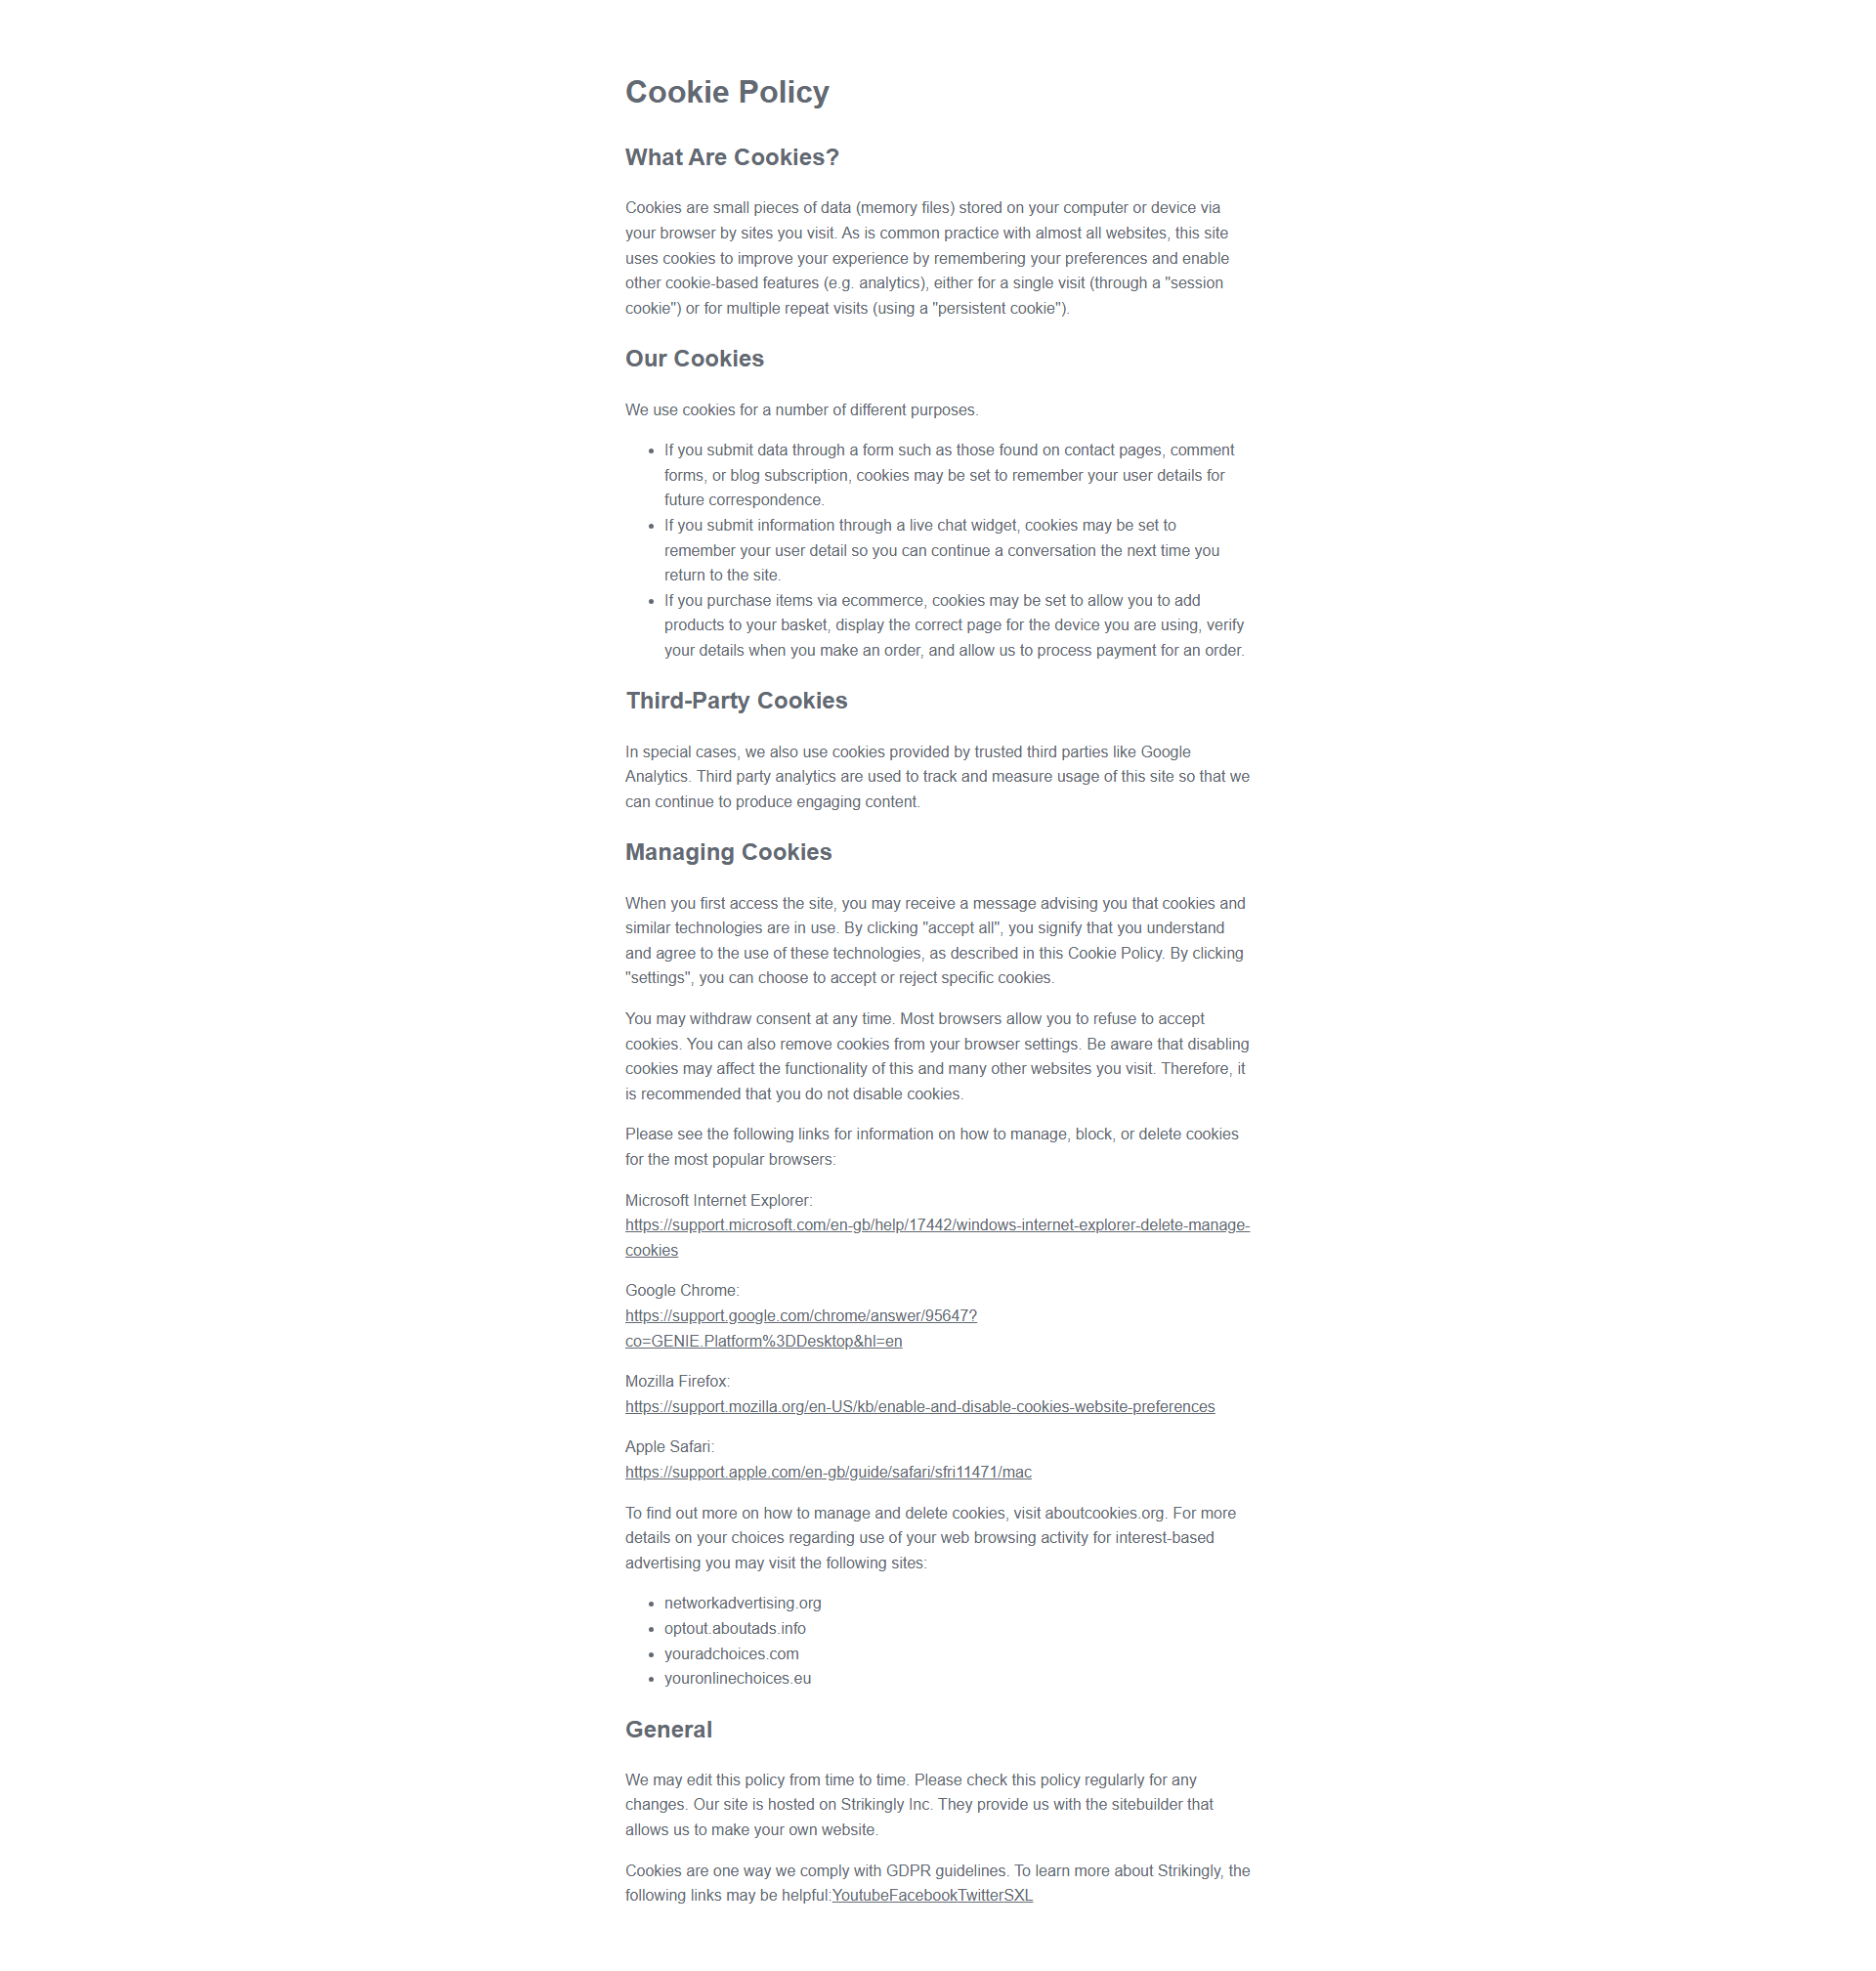

2025-05-14 17:02:23,121 [INFO] 448609275.py:62: Test html path: experiment-results\azure_sketch.py_gpt-4o_20250514-150000\7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4_merge-sketch_out.html


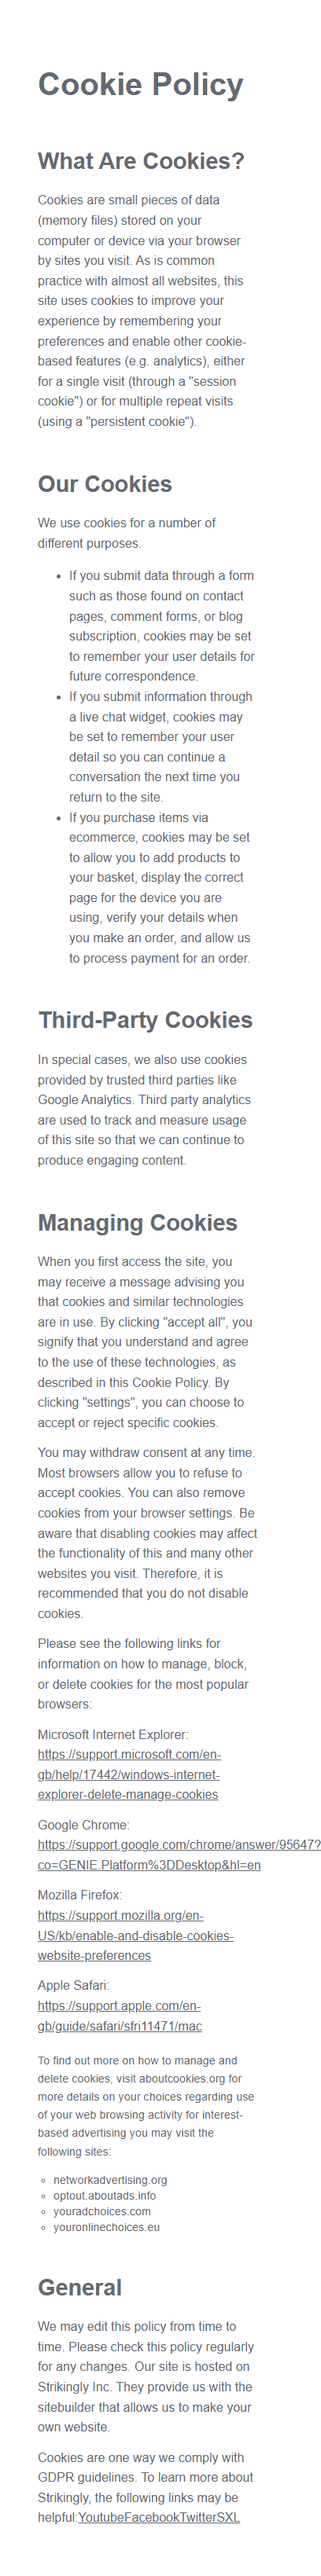

2025-05-14 17:02:27,959 [INFO] 448609275.py:82: Original html path: datasets/sketch\7b8b0aab78c0c3429254f3c224728be89112553daa72dd551e535670625008b4.html


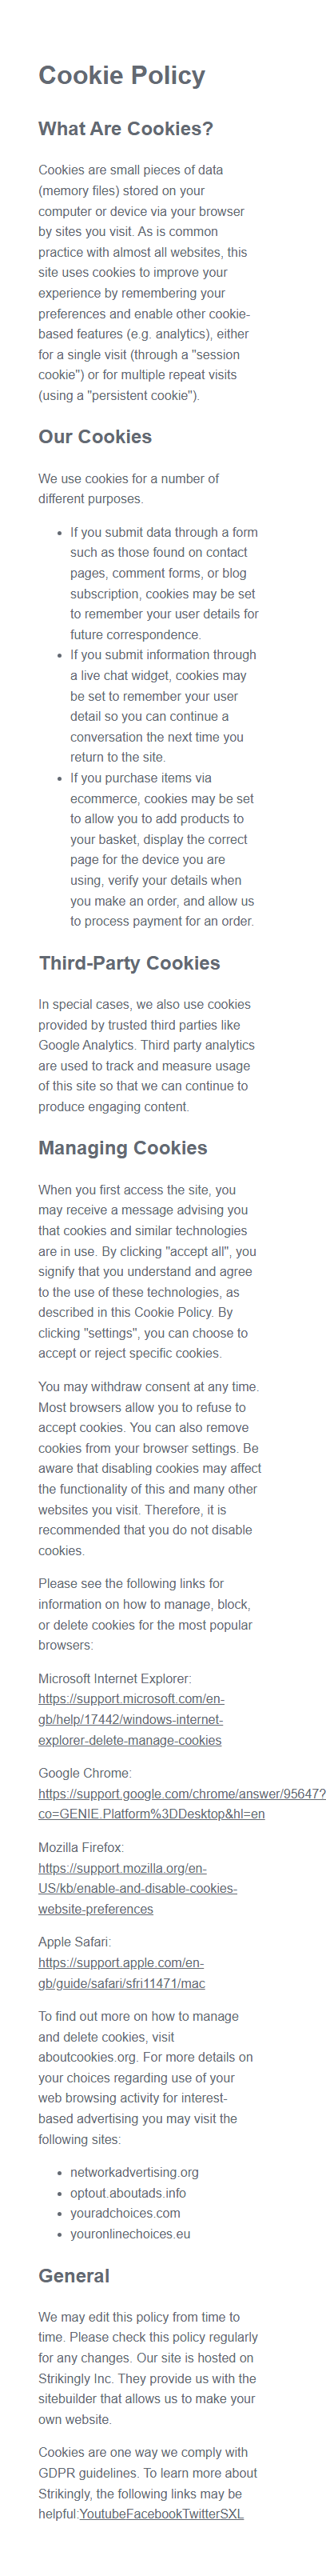

In [32]:
import time
from IPython.display import Image, display
def get_res_dict_by_uid_and_viewport(result_dir: str, uid_queries: list[str], viewport_queries: list[str]) -> dict:
    res_dict_list: list[dict[str, float]] = []

    visited_viewports = set()

    cur_dir = os.path.join(ALL_RESULTS_DIR, result_dir)

    if not os.path.isdir(cur_dir):
        logger.warning("Directory %s does not exist", cur_dir)
        return

    json_files = os.listdir(cur_dir)

    for json_file in json_files:
        if not json_file.startswith("res_dict_eval__") or not json_file.endswith(".json"):
            continue

        csv_file_name = json_file.split('__')[1].split(".")[0]
        json_file_path = os.path.join(cur_dir, json_file)

        json_data = {}

        with open(json_file_path, 'r') as f:
            json_data: dict[str, list[dict[str, any]]] = json.load(f)

        for viewport in CSV_WEIGHTAGES[csv_file_name].keys():
            if viewport not in json_data:
                logger.warning("Key %s not found in %s from %s",
                               viewport, json_file, cur_dir)
                continue

            if viewport in visited_viewports:
                continue
            visited_viewports.add(viewport)

            for res in json_data[viewport]:
                if "id" not in res:
                    logger.warning("Key %s not found in %s from %s",
                                   "id", json_file, cur_dir)
                    continue
                res["viewport"] = viewport
                res_dict_list.append(res)

    results = []
    for res_dict in res_dict_list:
        if res_dict["id"] in uid_queries and res_dict["viewport"] in viewport_queries:
            results.append(res_dict)
    return results


results = get_res_dict_by_uid_and_viewport(
    chosen_dir, uid_queries, viewport_queries)
logger.info("Results: %s", results)
# Open the images found in queries

for i, result in enumerate(results):
    html_dir = os.path.join(ALL_RESULTS_DIR, chosen_dir, result["filename"])
    temp_images_path = html_dir.replace(".html", ".png")
    temp_images_path = "temp" + str(i) + temp_images_path
    logger.info("Test html path: %s", html_dir)
    os.system("python -m utils.screenshot --url %s --output %s --viewport %s" %
              (html_dir, temp_images_path, result["viewport"]))
    time.sleep(3)
    if os.path.exists(temp_images_path):
        # Render it in the notebook
        display(Image(filename=temp_images_path))
        # delete the image after displaying
        try:
            os.remove(temp_images_path)
        except Exception as e:
            logger.warning(
                "Error deleting image %s: %s. You should remove it manually later", temp_images_path, e)
    else:
        logger.warning("Image %s not found", temp_images_path)

    original_html_path = os.path.join(
        original_design_dir, result["id"] + ".html")
    temp_images_path = original_html_path.replace(".html", ".png")
    temp_images_path = "temp" + str(i) + temp_images_path
    logger.info("Original html path: %s", original_html_path)
    os.system("python -m utils.screenshot --url %s --output %s --viewport %s" %
              (original_html_path, temp_images_path, result["viewport"]))
    time.sleep(3)
    if os.path.exists(temp_images_path):
        # Render it in the notebook
        display(Image(filename=temp_images_path))
        # delete the image after displaying
        try:
            os.remove(temp_images_path)
        except Exception as e:
            logger.warning(
                "Error deleting image %s: %s. You should remove it manually later", temp_images_path, e)
    else:
        logger.warning("Image %s not found", temp_images_path)